In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv('dataset_final_para_modelo.csv', decimal=',')
df

,latitude,longitude,data,hora,Sinistro,Chuva,tipo_via_num,tp_veiculo_bicicleta,tp_veiculo_caminhao,tp_veiculo_motocicleta,tp_veiculo_nao_disponivel,tp_veiculo_onibus,tp_veiculo_outros,tp_veiculo_automovel
0,-22.333684,-49.048348,2022-10-21,10,1,0,0.0,0,0,0,0,0,0,0
1,-22.301419,-49.048727,2022-07-30,22,0,0,0.0,0,0,0,0,0,0,0
2,-22.339661,-49.052127,2022-01-20,1,0,1,0.0,0,0,0,0,0,0,0
3,-22.316303,-49.013965,2024-12-07,17,1,0,0.0,0,0,1,0,0,0,1
4,-22.317141,-49.074546,2024-02-04,23,0,0,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24562,-22.367021,-48.994193,2024-08-11,10,0,1,0.0,0,0,0,0,0,0,0
24563,-22.278111,-49.074664,2025-01-04,23,1,0,0.0,0,0,1,0,1,0,0
24564,-22.228542,-49.229450,2024-12-22,19,0,0,0.0,0,0,0,0,0,0,0
24565,-22.305045,-49.106929,2023-08-20,12,1,0,0.0,0,0,1,0,0,0,0


### Separação de Features (X) e Alvo (y)

In [27]:
X = df.drop(columns=['Sinistro', 'data']) 
 
y = df['Sinistro']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=8, stratify=y
)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (17196, 12)
Tamanho do conjunto de teste: (7371, 12)


### Treinar o modelo

In [32]:
xgb_model = xgb.XGBClassifier(random_state=8,  
                              eval_metric='logloss',
                              scale_pos_weight = 1.8,
                              learning_rate=0.05,
                              n_estimators=200,
                              max_depth=8,
                              use_label_encoder=False)

xgb_model.fit(X_train, y_train)

c:\Users\pirsp\Documents\TCC\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:29:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


### GridSerachCV

In [31]:
param_grid = {
    'max_depth': [3, 5, 7, 8, 10],
    'learning_rate': [0.01, 0.1, 0.05],
    'n_estimators': [100, 200, 300, 400],
    'scale_pos_weight': [1.8, 2, 2.2, 2.5, 3.0]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 4. Execute a busca. Esta é a parte demorada.
print("Iniciando o GridSearchCV (isto pode demorar muito)...")
grid_search.fit(X_train, y_train)
print("GridSearchCV concluído.")

# 5. Veja os melhores parâmetros encontrados
print("\nMelhores parâmetros encontrados:")
print(grid_search.best_params_)

# 6. Veja a melhor pontuação F1-Score durante a validação cruzada
print("\nMelhor F1-Score (validação cruzada):")
print(grid_search.best_score_)

Iniciando o GridSearchCV (isto pode demorar muito)...
Fitting 3 folds for each of 300 candidates, totalling 900 fits


c:\Users\pirsp\Documents\TCC\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:27:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV concluído.

Melhores parâmetros encontrados:
{'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'scale_pos_weight': 1.8}

Melhor F1-Score (validação cruzada):
0.7315480595353172


### Proucurar o limiar ideial

In [34]:
# Calcule as probabilidades com este modelo superior
y_prob_best = xgb_model.predict_proba(X_test)[:, 1]

# Agora, vamos encontrar o melhor balanço para o RECALL
print("--- Testando Diferentes Limiares ---")

for limiar in [0.5, 0.45, 0.4, 0.35, 0.3]:
    y_pred_ajustado = (y_prob_best >= limiar).astype(int)
    
    # Usamos zero_division=0 para evitar avisos se uma métrica for zero
    report = classification_report(y_test, y_pred_ajustado, zero_division=0, output_dict=True)
    
    # Extrai as métricas para a classe 1 (Acidente)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']
    
    print(f"Limiar: {limiar:.2f} -> Precision={precision:.2f} | Recall={recall:.2f} | F1-Score={f1:.2f}")


--- Testando Diferentes Limiares ---
Limiar: 0.50 -> Precision=0.80 | Recall=0.67 | F1-Score=0.73
Limiar: 0.45 -> Precision=0.72 | Recall=0.74 | F1-Score=0.73
Limiar: 0.40 -> Precision=0.63 | Recall=0.81 | F1-Score=0.71
Limiar: 0.35 -> Precision=0.57 | Recall=0.87 | F1-Score=0.69
Limiar: 0.30 -> Precision=0.54 | Recall=0.90 | F1-Score=0.67


### Fazer previsões e avaliar as métricas

In [33]:
y_pred_xgb = xgb_model.predict(X_test)

print("\n--- Matriz de Confusão ---")
print(confusion_matrix(y_test, y_pred_xgb))
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred_xgb))

y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"--- AUC (XGBoost) ---")
print(f"{auc_xgb:.4f}")


--- Matriz de Confusão ---
[[4512  402]
 [ 821 1636]]

--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      4914
           1       0.80      0.67      0.73      2457

    accuracy                           0.83      7371
   macro avg       0.82      0.79      0.80      7371
weighted avg       0.83      0.83      0.83      7371

--- AUC (XGBoost) ---
0.8921


### SHAP (Shapley Additive exPlanations)

PermutationExplainer explainer: 7372it [07:17, 16.40it/s]                          
C:\Users\pirsp\AppData\Local\Temp\ipykernel_29172\2908890044.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_obj_xgb[:, :, 1], X_test, max_display=15, show=True)


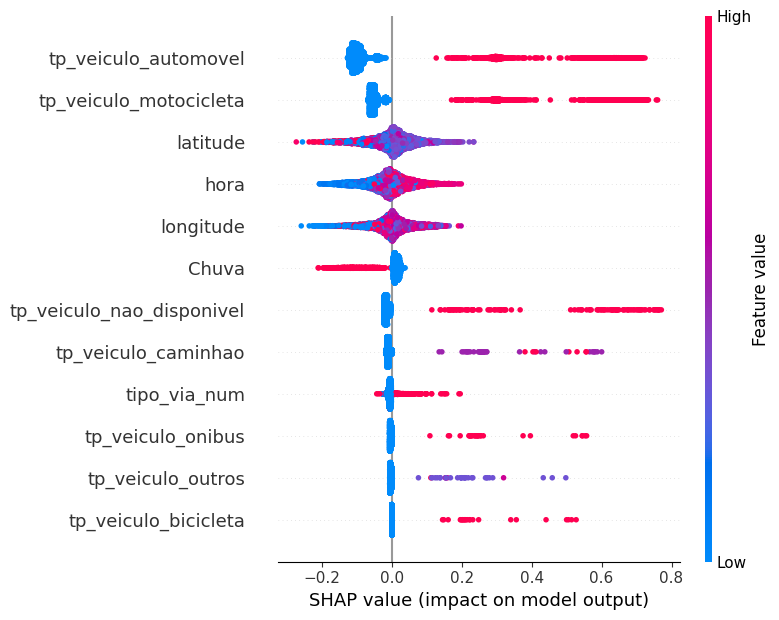

C:\Users\pirsp\AppData\Local\Temp\ipykernel_29172\2908890044.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_obj_xgb[:, :, 1], X_test, plot_type="bar", max_display=15, show=True)


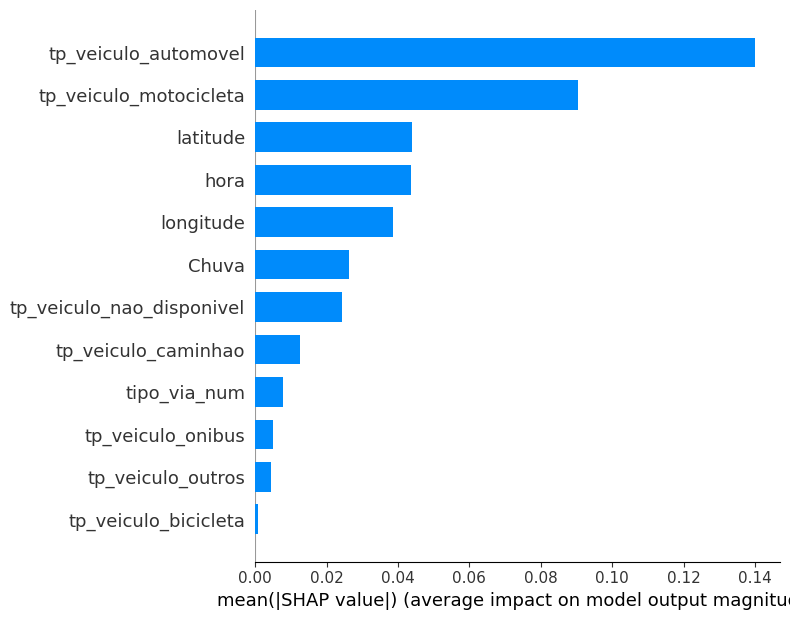

In [22]:
explainer_xgb = shap.Explainer(xgb_model.predict_proba, X_train)

shap_values_obj_xgb = explainer_xgb(X_test)

# Gráfico de Resumo Detalhado (Beeswarm) para a classe 1
shap.summary_plot(shap_values_obj_xgb[:, :, 1], X_test, max_display=15, show=True)

# Gráfico de Barras (Importância Global) para a classe 1
shap.summary_plot(shap_values_obj_xgb[:, :, 1], X_test, plot_type="bar", max_display=15, show=True)
